# This approach uses Word2Vec emedding to vectorize the description #


In [1]:
from gensim.models.keyedvectors import KeyedVectors
model_path = './GoogleNews-vectors-negative300.bin' #loading Word2Vec trained on Google News 
w2v_model = KeyedVectors.load_word2vec_format(model_path, binary=True)
print(w2v_model)

In [2]:
from nltk.corpus import stopwords
sw = stopwords.words("english")
print(sw)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [17]:
### Fetching data from mongo ###
from pymongo import MongoClient
import numpy as np
import pandas as pd

client = MongoClient('localhost', 27017)
db = client.apps
collection = db.app_name
print(collection)


df_apps = pd.DataFrame(list(collection.find({},{'_id':0, 'description': 1, 'category': 1, 'app_name': 1})))
df_apps["Length"]= df_apps["description"].str.len() # passing values through str.len() 
df_apps

Collection(Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'apps'), 'app_name')


,app_name,description,category,Length
0,Coloring book moana,Moana Coloring book pages is an educational co...,Arcade,1897
1,"U Launcher Lite – FREE Live Cool Themes, Hide ...",💘Try the best launcher for Android - U Launche...,Art & Design,2422
2,Sketch - Draw & Paint,*** The online parts of the Sketch service wil...,Art & Design,1961
3,Pixel Draw - Number Art Coloring Book,Enjoy number coloring and creating anti-stress...,Art & Design,1433
4,Paper flowers instructions,Papercraft flowers are crafted using simple ma...,Art & Design,3076
...,...,...,...,...
974,USAA Mobile,The USAA Mobile app gives you convenient and s...,Finance,1098
975,Associated Credit Union Mobile,Associated Credit Union’s Mobile Banking App i...,Finance,596
976,Bank of America Mobile Banking,Bank conveniently and securely with the Bank o...,Finance,3093
977,USE Credit Union Mobile,USE Credit Union Android App \nManage your acc...,Finance,700


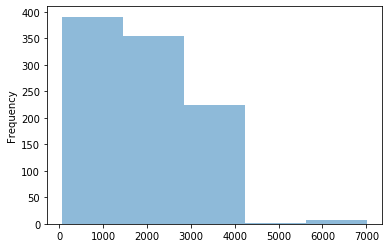

In [23]:
ax = df_apps['Length'].plot.hist(bins=5, alpha=0.5)
ax

In [6]:
test_df = pd.DataFrame(list(collection.find({'app_name': 'Flipkart'},{'_id':0, 'description': 1, 'category': 1, 'app_name': 1})))

In [31]:
def vectorize(description):
        """Identify the vector values for each word in the given document"""
        description = description.lower()
        words = [w for w in description.split(" ") if w not in sw]
        word_vecs = []
        for word in words:
            try:
                vec = w2v_model[word]
                word_vecs.append(vec)
            except KeyError:
                # Ignore, if the word doesn't exist in the vocabulary
                pass

        # Assuming that document vector is the mean of all the word vectors
        # PS: There are other & better ways to do it.
        vector = np.mean(word_vecs, axis=0)
        return vector
    
def _cosine_sim(vecA, vecB):
        """Find the cosine similarity distance between two vectors."""
        csim = np.dot(vecA, vecB) / (np.linalg.norm(vecA) * np.linalg.norm(vecB))
        if np.isnan(np.sum(csim)):
            return 0
        return csim
    
def calculate_similarity(source_df, target_df, threshold=0, category = True):
        """Calculates & returns similarity scores between given source document & all
        the target documents."""
        source_name = source_df['app_name'].values[0]
        print("Source_name >> ",source_name)
        source_doc = str(source_df['description'].values[0])
        source_cat = str(source_df['category'].values[0])
        print("Source_category >> ", source_cat)
        source_vec = vectorize(source_doc)
        results = []
        if category == True:
            target_df = target_df[target_df['category'] == source_cat]
        for index, row in target_df.iterrows():
            target_vec = vectorize(row['description'])
            sim_score = _cosine_sim(source_vec, target_vec)
            if sim_score > threshold:
                results.append({
                    'score' : sim_score,
                    'name' : row['app_name']
                })
            # Sort results by score in desc order
            results.sort(key=lambda k : k['score'] , reverse=True)

        return results


In [34]:
## Getting results when pre-defined categories are taken into consideration ##
sim_scores = calculate_similarity(test_df, df_apps, category = True)
sim_scores[:10]

Source_name >>  Flipkart
Source_category >>  Shopping


[{'score': 0.99999994, 'name': 'Flipkart'},
 {'score': 0.9365793, 'name': 'HomeShop18'},
 {'score': 0.9348917, 'name': 'Snapdeal'},
 {'score': 0.9258636, 'name': 'Amazon'},
 {'score': 0.925186, 'name': 'DHgate Mobile online wholesale'},
 {'score': 0.925186, 'name': 'DHgate Mobile'},
 {'score': 0.8775137, 'name': 'ASOS'},
 {'score': 0.8734439, 'name': 'Forever 21'},
 {'score': 0.8732123, 'name': 'Shopping at DealExtreme'},
 {'score': 0.8711715, 'name': 'eBay'}]

In [33]:
## Getting results when pre-defined categories are NOT taken into consideration ##
sim_scores = calculate_similarity(test_df, df_apps, category = False)
sim_scores[:10]

Source_name >>  Flipkart
Source_category >>  Shopping


[{'score': 0.99999994, 'name': 'Flipkart'},
 {'score': 0.9365793, 'name': 'HomeShop18'},
 {'score': 0.9348917, 'name': 'Snapdeal'},
 {'score': 0.9258636, 'name': 'Amazon'},
 {'score': 0.925186, 'name': 'DHgate Mobile online wholesale'},
 {'score': 0.925186, 'name': 'DHgate Mobile'},
 {'score': 0.9018686, 'name': 'BBVA Compass Banking'},
 {'score': 0.897361, 'name': 'sABN'},
 {'score': 0.8913565, 'name': 'My Vodacom SA'},
 {'score': 0.88756067, 'name': 'Ecobank Mobile Banking'}]